## Mode of Simulation 

Three type of simulation 

<strong>1. Profit maximization</strong> 

<strong>2. Solo Rides</strong>

<strong>3. Pooled Rides</strong>

## Load ExMAS and MaaSSim


In [13]:
%load_ext autoreload
%autoreload 2
import os, sys # add MaaSSim to path (not needed if MaaSSim is already in path)
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from MaaSSim.utils import get_config, load_G, prep_supply_and_demand, generate_demand, generate_vehicles, initialize_df  # simulator
from MaaSSim.data_structures import structures as inData
from MaaSSim.simulators import simulate
from MaaSSim.visualizations import plot_veh
from MaaSSim.shared import prep_shared_rides
from MaaSSim.performance import kpi_pax_pricing
from MaaSSim.performance import kpi_veh_pricing


import logging
import matplotlib.pyplot as plt


import pandas as pd
import ExMAS

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Delft, Netherlands

In [14]:
params = get_config('../../data/config/delft.json')  # load configuration

params.times.pickup_patience = 3600 # 1 hour of simulation
params.simTime = 1 # 6 minutes hour of simulation
params.nP = 50 # reuqests (and passengers)
params.nV = 20 # vehicles


## Parameters for ExMAS

In [15]:
params.t0 = pd.Timestamp.now()
params.shareability.avg_speed = params.speeds.ride
params.shareability.shared_discount = 0.25
params.shareability.delay_value = 1
params.shareability.WtS = 1.3
params.shareability.price = 1.5 #eur/km
params.shareability.VoT = 0.0035 #eur/s
params.shareability.matching_obj = 'u_veh' #minimize VHT for vehicles
params.shareability.pax_delay = 0
params.shareability.horizon = 600
params.shareability.max_degree = 4
params.shareability.nP = params.nP
params.shareability.share = 1
params.shareability.without_matching = True
params.shareability.operating_cost = 0.0005
params.shareability.comm_rate = 0.2

inData = load_G(inData, params)  # load network graph 

inData = generate_demand(inData, params, avg_speed = False)
inData.vehicles = generate_vehicles(inData,params.nV)
inData.vehicles.platform = inData.vehicles.apply(lambda x: 0, axis = 1)
inData.passengers.platforms = inData.passengers.apply(lambda x: [0], axis = 1)
inData.requests['platform'] = inData.requests.apply(lambda row: inData.passengers.loc[row.name].platforms[0], axis = 1) 
inData.platforms = initialize_df(inData.platforms)
inData.platforms.loc[0]=[1,'Uber',30]
params.shareability.share = 1
params.shareability.without_matching = True



# params.kpi = 1 (Profit Maximazation)
# params.kpi = 2 (Solo Rides)
# params.kpi = 3 (Pooled Rides)


In [16]:
params.kpi = 1


### Profit Mazimization - Begin 

In [17]:
#inData = ExMAS.main(inData, params.shareability) # create shareability graph (ExMAS) 
inData = ExMAS.main(inData, params.shareability, plot = False)

24-07-23 18:00:57-INFO-Initializing pairwise trip shareability between 50 and 50 trips.
24-07-23 18:00:57-INFO-creating combinations
24-07-23 18:00:57-INFO-2450	 nR*(nR-1)
24-07-23 18:00:57-INFO-Reduction of feasible pairs by 99.59%
24-07-23 18:00:57-INFO-Degree 2 	Completed
24-07-23 18:00:57-INFO-trips to extend at degree 2 : 26
24-07-23 18:00:57-INFO-At degree 2 feasible extensions found out of 0 searched
24-07-23 18:00:57-INFO-Degree 3 	Completed
24-07-23 18:00:57-INFO-No more trips to exted at degree 3


In [18]:
inData = prep_shared_rides(inData, params.shareability) # prepare schedules

24-07-23 18:00:58-INFO-Matching 50 trips to 76 rides in order to min u_veh
24-07-23 18:00:58-INFO-Problem solution: Optimal. 
Total costs for single trips:         13,350 
reduced by matching to:               12,478


In [19]:
inData.sblts.rides

,indexes,u_pax,u_veh,kind,u_paxes,times,indexes_orig,indexes_dest,degree,index,...,row,selected,nodes,req_id,sim_schedule,ttrav,dist,fare,commission,driver_revenue
0,[0],9.795500,529,1,[9.7955],"[0, 529]",[0],[0],1,0,...,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1,"[None, 1448535795, 44896902]","[None, 0, 0]",node time req_id od 0 ...,529,5.29,7.944000,1.588800,6.3552
1,[1],4.093000,221,1,[4.093],"[21, 221]",[1],[1],1,1,...,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1,"[None, 3510592637, 1851699236]","[None, 1, 1]",node time req_id od 0 ...,221,2.21,3.319500,0.663900,2.6556
2,[2],11.029000,596,1,[11.029],"[56, 596]",[2],[2],1,2,...,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1,"[None, 889276763, 3905428979]","[None, 2, 2]",node time req_id od 0 ...,596,5.96,8.943000,1.788600,7.1544
3,[3],3.584000,193,1,[3.584],"[149, 193]",[3],[3],1,3,...,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1,"[None, 1571087942, 44750625]","[None, 3, 3]",node time req_id od 0 ...,193,1.93,2.908500,0.581700,2.3268
4,[4],3.737000,202,1,[3.7369999999999997],"[189, 202]",[4],[4],1,4,...,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",1,"[None, 527060635, 1393024898]","[None, 4, 4]",node time req_id od 0 ...,202,2.02,3.030000,0.606000,2.4240
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,"[43, 48]",12.042975,735,21,"[9.352825, 2.69015]","[3045.5, 320, 164, 251]","[43, 48]","[48, 43]",2,71,...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,"[None, 44833503, 44837441, 1391531564, 565046997]","[None, 43, 48, 48, 43]",node time req_id od 0 ...,735,7.35,7.756875,1.551375,6.2055
72,"[43, 46]",12.718275,750,21,"[9.7009, 3.017375]","[2941.0, 464, 167, 119]","[43, 46]","[46, 43]",2,72,...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,"[None, 44833503, 44863714, 44833576, 565046997]","[None, 43, 46, 46, 43]",node time req_id od 0 N...,750,7.50,7.790625,1.558125,6.2325
73,"[43, 49]",10.923475,712,21,"[9.305050000000001, 1.6184250000000002]","[2990.0, 435, 92, 185]","[43, 49]","[49, 43]",2,73,...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,"[None, 44833503, 3581094285, 44795675, 565046997]","[None, 43, 49, 49, 43]",node time req_id od 0 ...,712,7.12,6.955875,1.391175,5.5647
74,"[35, 40]",12.820050,724,21,"[9.166525, 3.653525]","[2528.5, 280, 219, 225]","[35, 40]","[40, 35]",2,74,...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,"[None, 44871342, 44798698, 1421472381, 1774593...","[None, 35, 40, 40, 35]",node time req_id od 0 ...,724,7.24,8.151750,1.630350,6.5214


In [20]:
sim = simulate(params=params, inData = inData,  kpi_veh=kpi_veh_pricing,kpi_pax=kpi_pax_pricing, logger_level=logging.WARNING)

24-07-23 18:00:59-INFO-Matching 50 trips to 76 rides in order to min u_veh
24-07-23 18:00:59-INFO-Problem solution: Optimal. 
Total costs for single trips:         13,350 
reduced by matching to:               12,478
24-07-23 18:01:00-WARNING-Setting up 1h simulation at 2023-07-24 17:32:21 for 20 vehicles and 50 passengers in Delft, Netherlands
0.0005
24-07-23 18:01:00-CRITICAL-this is request 0 with [0, 57, 68] available rides.
24-07-23 18:01:00-CRITICAL-ride 0 available [1]
24-07-23 18:01:00-CRITICAL-ride 57 available [1, 0]
24-07-23 18:01:00-CRITICAL-ride 68 available [1, 0]
24-07-23 18:01:00-CRITICAL-this is reuqest 0 with [0, 57, 68] still available rides.
24-07-23 18:01:00-CRITICAL-vehicle 1 has 3 choices
0.0005
24-07-23 18:01:00-CRITICAL-this is request 1 with [1] available rides.
24-07-23 18:01:00-CRITICAL-ride 1 available [1]
24-07-23 18:01:00-CRITICAL-this is reuqest 1 with [1] still available rides.
24-07-23 18:01:00-CRITICAL-vehicle 2 has 1 choices
0.0005
24-07-23 18:01:00-

AttributeError: 'DataFrame' object has no attribute 'driver_revenue'

In [ ]:
#sim = simulate(params = params, inData = inData,  logger_level = logging.CRITICAL) # simulate

In [ ]:
sim.res[0].veh_exp

In [103]:
sim.vehs[3].rdf

,indexes,u_pax,u_veh,kind,u_paxes,times,indexes_orig,indexes_dest,degree,index,...,sim_schedule,ttrav,dist,fare,commission,driver_revenue,pickup_dist,trav_dist,operating_cost,profit
79,"[32, 41]",12.5403,821,21,"[10.538025000000001, 2.002275]","[2387.0, 410, 116, 295]","[32, 41]","[41, 32]",2,79,...,node time req_id od 0 N...,821,8.21,7.94025,1.58805,6.3522,4714,4722.21,2.361105,3.991095


In [104]:
pd.DataFrame(sim.vehs[3].myrides)

,veh,pos,t,event,paxes
0,3,1.391417e+09,0,STARTS_DAY,[]
1,3,1.391417e+09,0,OPENS_APP,[]
2,3,1.391417e+09,2834,RECEIVES_REQUEST,[]
3,3,1.391417e+09,2849,ACCEPTS_REQUEST,[]
4,3,1.391417e+09,2869,IS_ACCEPTED_BY_TRAVELLER,[None]
5,3,4.487399e+07,2925,ARRIVES_AT_PICKUP,[]
6,3,4.487399e+07,2925,MEETS_TRAVELLER_AT_PICKUP,[]
7,3,4.487399e+07,2955,DEPARTS_FROM_PICKUP,[41]
8,3,4.486755e+07,3071,ARRIVES_AT_DROPOFF,[41]
9,3,4.486755e+07,10799,ENDS_SHIFT,[]


<AxesSubplot:>

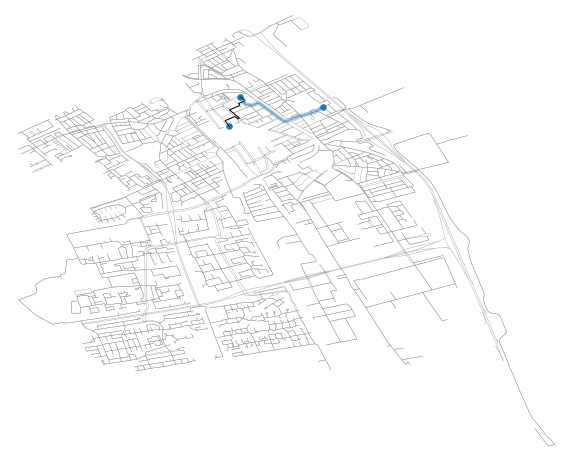

In [115]:
df = sim.runs[0].rides

for i in range(params.nV):
    paxes = df[df.veh==i].paxes
    if paxes.apply(lambda x: len(x)).max()>1:
        break
plot_veh(inData.G, df[df.veh ==3], lw = 1)

In [12]:
responses = []
avg_kpi = []
idle_time = []

for i in range(2, 3):
    params.kpi = i
    sim = simulate(params=params, inData = inData,  kpi_veh=kpi_veh_pricing,kpi_pax=kpi_pax_pricing, logger_level=logging.WARNING)
    #sim = simulate(params = params, inData = inData, logger_level = logging.CRITICAL) # simulate
    sim.res[0].veh_kpi.to_csv('D:/Development/GitHub-ProjectV2.0/MaaSSim/docs/tutorials/Results/Simulation/Driver/Test/veh{}.csv'.format(i))
    sim.res[0].pax_kpi.to_csv('D:/Development/GitHub-ProjectV2.0/MaaSSim/docs/tutorials/Results/Simulation/Driver/Test/pax{}.csv'.format(i))
    #driver_data.loc['Cost'] = driver_data.loc['Revenue'].apply(lambda x: x*params.shareability.operating_cost)['Vehicles'] = sim.res[0].veh_exp.index
    #sim.res[0].veh_exp['ds'] = f"{i}"
    
    #responses.append(sim.res[0].veh_exp)
     
   # vehicles = sim.res[0].veh_exp.loc[sim.res[0].veh_exp["nRIDES"] > 0]
    #no_of_veh = len(vehicles)
    
    #avg_kpi.append(sim.res[0].all_kpi/no_of_veh)
    #idle_time.append(vehicles['IDLE'].sum()/no_of_veh)
    
    #_inData.sblts.rides['commission'] = _inData.sblts.rides.apply(lambda row: row.fare*sp.comm_rate, axis=1)
    

24-07-23 17:49:49-WARNING-Setting up 1h simulation at 2023-07-24 15:03:59 for 20 vehicles and 50 passengers in Delft, Netherlands
24-07-23 17:49:49-WARNING-Nobody likes each other, Qs 1veh; 1req; tabu 2
24-07-23 17:49:49-WARNING-Nobody likes each other, Qs 2veh; 1req; tabu 3
24-07-23 17:49:49-WARNING-Nobody likes each other, Qs 3veh; 1req; tabu 4
24-07-23 17:49:49-WARNING-Nobody likes each other, Qs 4veh; 1req; tabu 5
24-07-23 17:49:49-WARNING-Nobody likes each other, Qs 5veh; 1req; tabu 6
24-07-23 17:49:49-WARNING-Nobody likes each other, Qs 6veh; 1req; tabu 7
24-07-23 17:49:49-WARNING-Nobody likes each other, Qs 7veh; 1req; tabu 8
24-07-23 17:49:49-WARNING-Nobody likes each other, Qs 8veh; 1req; tabu 9
24-07-23 17:49:49-WARNING-Nobody likes each other, Qs 9veh; 1req; tabu 10
24-07-23 17:49:49-WARNING-Nobody likes each other, Qs 10veh; 1req; tabu 10
24-07-23 17:49:50-WARNING-Nobody likes each other, Qs 11veh; 1req; tabu 11
24-07-23 17:49:50-WARNING-Nobody likes each other, Qs 12veh; 1

AttributeError: 'DataFrame' object has no attribute 'driver_revenue'